# Geos-Chem analysis

Este notebook possibilita realizar a análise da saída do Geos-Chem. Ele conta com instruções para:

- Abertura do arquivo de saída em formatos `netcdf` e `bpch`
- Leitura das variáveis, atributos e coordenadas
- Exibição da concentração do elemento químico com e sem cartografia
- Exibição interativa com seleção da variável e lev

Importação das bibliotecas:

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

from ipywidgets import interact, SelectionSlider, IntSlider, Dropdown
from temp.gamap_colormap import WhGrYlRd
from math import ceil
import matplotlib.pyplot as plt
import ipywidgets as widgets
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
import warnings
import xbpch

warnings.filterwarnings("ignore")  # hide some xbpch warnings

## Global variables

Caminhos para os arquivos:

- `trac`: arquivo de saída do Geos-Chem, normalmente em formato bpch our netcdf
- `tracerinfo` e `diaginfo`: caso `trac` esteja em formato bpch, os arquivos [tracerinfo|diaginfo].dat são necessários para leitura
- `f_out`: caminho para salvar as figuras do plot, caso seja habilitada nas funções

In [3]:
# Files path
ARGS = {
    "trac": "temp/geos45s_1/trac_avg.geosfp_4x5_standard.201501010000",
    "tracerinfo": "temp/geos45s_1/tracerinfo.dat",
    "diaginfo": "temp/geos45s_1/diaginfo.dat",
    "f_out": lambda x, l, t: f"out/img/{x}_lev_{l}_{t}.png",
}

## Functions

Função para retornar um array com elementos de `0...(variable - 1)`

_Exemplo:_

- variable = 2 -> rlen(variable) = [0, 1]
- variable = 5 -> rlen(variable) = [0, 1, 2, 3, 4]

In [4]:
def rlen(variable):
    return range(len(variable))

Função para exibir os dados por plot em mapa cartográfico.

- `emiss`: xarray com os dados de saída do Geos-Chem
- `tracers`: uma lista das variáveis que deseja exibir
- `times`: uma lista de inteiros com os índices dos times da simulação
- `levs`: uma lista de inteiros com as `lev` que deseja exibir
- `save`: um boleano indicando se deseja salvar a(s) imagem(es) de output

In [5]:
def plot_static(
    emiss: xr.Dataset,
    tracers: [str],
    times: [int],
    levs: [int],
    save: bool = False
):
    emissions = emiss[tracers]
    full_time = emissions.time.values
    time_size = len(times)
    # Row and col dynamic processing for subplots
    rows = ceil(time_size/2)
    cols = 1 if time_size == 1 else 2
    
    # Get each tracer in emissions xarray
    for tracer in emissions.values():
        print(f"TRACER {tracer.name}")
        
        # Check if exists lev on tracer
        have_lev = True
        identified_levs = levs
        
        if "lev" not in tracer.dims:
            have_lev = False
            identified_levs = ["the is no lev"]
        
        # Get each lev
        for l in identified_levs:
            print(f"LEV {l}")
            
            # Create the subplots
            fig, axes = plt.subplots(
                rows,
                cols,
                figsize=(15, 5),
                subplot_kw={"projection": ccrs.PlateCarree()}
            )
            
            # Prepare `isel` parameters
            kwargs = {}
            if have_lev:
                kwargs["lev"] = l

            # Plot diagnotics for each time
            for ax, t in zip(axes, times):
                kwargs["time"] = t # adds time in parameters
                tracer.isel(**kwargs).plot(
                    ax=ax,
                    cmap=WhGrYlRd,
                    vmin=0,
                    cbar_kwargs={"shrink": 0.5, "label": "ppbv"},
                )
                ax.set_title(f"{tracer.name} lev {l} - {full_time[t]}")
                ax.coastlines()
                ax.gridlines(linestyle="--")
            
            plt.show()
                
            if save:
                plt.savefig(ARGS["f_out"](tracer.name, l, full_time[t]))

## Analysis

Leitura do arquivo `bpch` ou `netcdf`. É necessário identificar qual o formato do seu arquivo de saída. `netcdf` é possível a partir da versão _v11-02a_.

__bpch__ é o formato _default_ do Geos-Chem, embora sera retirado na versão 12.7 sendo substituido pelo `netcdf`.
Para abrir o `bpch` é preciso informar os arquivos __.dat__ que contém os nomes dos rastreadores e alguns metadados necessários.

__netcdf__, diferente do `bpch`, é um formato completo e robusto sendo auto suficiente para apresentar qualquer informação, no mesmo arquivo existem os metadados e os nomes dos rasteradores. Desse modo, para o `netcdf`, basta ele próprio.

Devido estarmos utilizando o xarray e o xbpch (interface para o xarray), o único comando que diferencia a forma de trabalho com esses arquivos é a própria abertura. Todos os próximos comandos mantem a mesma estrutura independente do formato.

### Abertura e visualização dos dados:

In [6]:
# Open bpch
df_trac = xbpch.open_bpchdataset(
    ARGS["trac"],
    tracerinfo_file=ARGS["tracerinfo"],
    diaginfo_file=ARGS["diaginfo"],
)

# Open netcdf
# df_trac = xr.open_dataset(ARGS["trac"])

df_trac

<xarray.Dataset>
Dimensions:            (lat: 46, lev: 72, lev_edge: 73, lon: 72, nv: 2, time: 2)
Coordinates:
  * lev                (lev) float64 0.9925 0.9775 ... 1.614e-05 4.935e-06
  * lon                (lon) float64 -180.0 -175.0 -170.0 ... 165.0 170.0 175.0
  * lat                (lat) float64 -89.0 -86.0 -82.0 -78.0 ... 82.0 86.0 89.0
  * time               (time) datetime64[ns] 2015-01-01 2015-02-01
  * nv                 (nv) int64 0 1
Dimensions without coordinates: lev_edge
Data variables:
    PL_SUL_S_SO2dms    (time, lon, lat, lev) float32 dask.array<chunksize=(1, 72, 46, 72), meta=np.ndarray>
    time_bnds          (time, nv) datetime64[ns] 2015-01-01 ... 2015-03-01
    PL_SUL_S_SO2no3    (time, lon, lat, lev) float32 dask.array<chunksize=(1, 72, 46, 72), meta=np.ndarray>
    PL_SUL_S_SO2tot    (time, lon, lat, lev) float32 dask.array<chunksize=(1, 72, 46, 72), meta=np.ndarray>
    PL_SUL_S_MSAdms    (time, lon, lat, lev) float32 dask.array<chunksize=(1, 72, 46, 72), me

Listar todas variáveis existentes no arquivo:

In [7]:
variables = list(df_trac.data_vars)
variables.sort() # ordena
variables

['ACETSRCE_ACETbg',
 'ACETSRCE_ACETmb',
 'ACETSRCE_ACETmo',
 'ACETSRCE_ACETop',
 'ANTHSRCE_ACET',
 'ANTHSRCE_ALD2',
 'ANTHSRCE_ALK4',
 'ANTHSRCE_BCPI',
 'ANTHSRCE_BCPO',
 'ANTHSRCE_BENZ',
 'ANTHSRCE_C2H6',
 'ANTHSRCE_C3H8',
 'ANTHSRCE_CH2O',
 'ANTHSRCE_CH4',
 'ANTHSRCE_CO',
 'ANTHSRCE_EOH',
 'ANTHSRCE_HNO2',
 'ANTHSRCE_MACR',
 'ANTHSRCE_MEK',
 'ANTHSRCE_NH3',
 'ANTHSRCE_NO',
 'ANTHSRCE_NO2',
 'ANTHSRCE_O3',
 'ANTHSRCE_OCPI',
 'ANTHSRCE_OCPO',
 'ANTHSRCE_PRPE',
 'ANTHSRCE_RCHO',
 'ANTHSRCE_SO2',
 'ANTHSRCE_SO4',
 'ANTHSRCE_TOLU',
 'ANTHSRCE_XYLE',
 'BC_ANTH_BLKC',
 'BC_BIOB_BLKC',
 'BC_BIOF_BLKC',
 'BIOBSRCE_ACET',
 'BIOBSRCE_ALD2',
 'BIOBSRCE_ALK4',
 'BIOBSRCE_BC',
 'BIOBSRCE_BENZ',
 'BIOBSRCE_C2H6',
 'BIOBSRCE_C3H8',
 'BIOBSRCE_CH2O',
 'BIOBSRCE_CH4',
 'BIOBSRCE_CO',
 'BIOBSRCE_EOH',
 'BIOBSRCE_HNO3',
 'BIOBSRCE_MEK',
 'BIOBSRCE_MGLY',
 'BIOBSRCE_MTPA',
 'BIOBSRCE_NH3',
 'BIOBSRCE_NO',
 'BIOBSRCE_OC',
 'BIOBSRCE_PAN',
 'BIOBSRCE_PRPE',
 'BIOBSRCE_SO2',
 'BIOBSRCE_TOLU',
 'BIOBSRCE_XYL

É possível selecionar uma variável específica por manipulação do `df_trac`:

In [8]:
df_trac["IJ_AVG_S_CO"]

<xarray.DataArray 'IJ_AVG_S_CO' (time: 2, lon: 72, lat: 46, lev: 72)>
dask.array<mul, shape=(2, 72, 46, 72), dtype=float32, chunksize=(1, 72, 46, 72), chunktype=numpy.ndarray>
Coordinates:
  * lev      (lev) float64 0.9925 0.9775 0.9624 ... 1.614e-05 4.935e-06
  * lon      (lon) float64 -180.0 -175.0 -170.0 -165.0 ... 165.0 170.0 175.0
  * lat      (lat) float64 -89.0 -86.0 -82.0 -78.0 -74.0 ... 78.0 82.0 86.0 89.0
  * time     (time) datetime64[ns] 2015-01-01 2015-02-01
Attributes:
    number:          4
    category:        IJ-AVG-$
    name:            CO
    full_name:       CO tracer
    molwt:           0.028
    C:               1
    tracer:          4
    hydrocarbon:     False
    chemical:        True
    original_shape:  (72, 46, 72)
    origin:          (1, 1, 1)
    scale_factor:    1000000000.0
    units:           ppbv

Existem duas variáveis que podem ser descartadas por não serem muito úteis:

- `time_bnds`: limites de tempo
- `nv`: dimensão redundante

Exibição dos `time_bnds`:

In [9]:
df_trac["time_bnds"]

<xarray.DataArray 'time_bnds' (time: 2, nv: 2)>
array([['2015-01-01T00:00:00.000000000', '2015-02-01T00:00:00.000000000'],
       ['2015-02-01T00:00:00.000000000', '2015-03-01T00:00:00.000000000']],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2015-01-01 2015-02-01
  * nv       (nv) int64 0 1
Attributes:
    units:    hours since 1985-01-01 00:00:00

Exibição da `nv`:

In [10]:
df_trac["nv"]

<xarray.DataArray 'nv' (nv: 2)>
array([0, 1])
Coordinates:
  * nv       (nv) int64 0 1

Descarte:

In [11]:
df_trac = df_trac.drop("time_bnds")
df_trac = df_trac.drop("nv")

Conforme citado, existem três tipos de componentes na estrutura: as variáveis, coordenadas e atributos. Anteriormente foi explicado como é possível obter a lista de variáveis presentes no arquivo, abaixo será abordado como obter as coordenadas e atributos.

Coordenadas existentes em CO:

In [12]:
df_trac["IJ_AVG_S_CO"].coords

Coordinates:
  * lev      (lev) float64 0.9925 0.9775 0.9624 ... 1.614e-05 4.935e-06
  * lon      (lon) float64 -180.0 -175.0 -170.0 -165.0 ... 165.0 170.0 175.0
  * lat      (lat) float64 -89.0 -86.0 -82.0 -78.0 -74.0 ... 78.0 82.0 86.0 89.0
  * time     (time) datetime64[ns] 2015-01-01 2015-02-01

É possível também obter a lista através de `dims`

In [13]:
df_trac["IJ_AVG_S_CO"].dims

('time', 'lon', 'lat', 'lev')

Atributos existentes em CO:

In [14]:
df_trac["IJ_AVG_S_CO"].attrs

{'number': 4,
 'category': 'IJ-AVG-$',
 'name': 'CO',
 'full_name': 'CO tracer',
 'molwt': 0.028,
 'C': 1,
 'tracer': 4,
 'hydrocarbon': False,
 'chemical': True,
 'original_shape': (72, 46, 72),
 'origin': (1, 1, 1),
 'scale_factor': 1000000000.0,
 'units': 'ppbv'}

O comando `values` possibilita o acesso a todos os valores existentes da matriz multidimensional (`df_trac["IJ_AVG_S_CO"].values`). Porém, recomendo o uso de `sel` ou `isel` que permite o acesso as n-dimensões semelhante ao `loc` e `iloc` do numpy (`df_trac["IJ_AVG_S_CO"].isel(time=0, lev=0)`).

Mais informações em [indexing with xarray](http://xarray.pydata.org/en/stable/indexing.html).

### Manipulação do arquivo

Algumas variáveis possuem dimensão 4D. A ordem convencional é (time, lev, lat, lon), no `bpch` é observado a ordem (time, lon, lat, lev). Com a função `transpose` é possível alterar a ordem da dimensionalidade.

_Obs: verifique se na sua entrada não existem variáveis com dimensões divergentes, caso exista, antes de executar o comando abaixo é necessário que extraia apenas as variáveis que respeitem a dimensão com as coordenadas informadas. Uma forma de extrair apenas essas variáveis pode ser feitas através do comando:_

- `df_extracao = df_trac[[lista_de_variáveis_de_interesse]]`

_Exemplo:_ Obtendo os dados das concentrações de __O3__ e __SO2__

- `df_extracao = df_trac[['IJ_AVG_S_O3', 'IJ_AVG_S_SO2']]`

_Desse modo, as manipulações podem ser feitas sobre a variável df_extracao_

_Obs: O formato bpch inverte a dimensionalidade entre lat e lon, prejudicando a exibição real. `transpose` pode corrigir esse problema._

In [24]:
# df_trac = df_trac.transpose("time", "lev", "lat", "lon")
df_trac = df_trac.transpose()

É possível também converter o arquivo `bpch` para `netcdf`:

In [25]:
df_trac = xbpch.common.fix_attr_encoding(df_trac)
df_trac.to_netcdf(f"{ARGS['trac']}.nc")

Caso possua o `ncdump` instalado, é possível executar o comando do terminal de leitura do arquivo:

O caracter __!__ indica a o jupyter que o comando deve ser executado no terminal.

In [26]:
# !ncdump -h caminho_do_trac.nc

### Plot

Esse notebook foi desenvolvido com objetivo de possibilitar uma análise gráfica estática e dinâmica. A função `plot_static`, apresentada no inicio do documento, possibilita selecionar as variáveis, períodos e lev específicos para plotagem e salvar seu output. Enquanto que a função `plot_dynamic`, apresentado abaixo, possibilita uma visualização interativa.

#### Static

TRACER ACETSRCE_ACETbg
LEV the is no lev


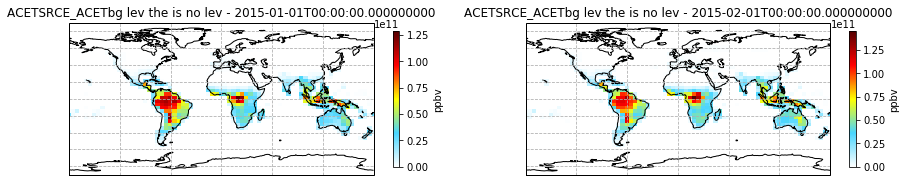

TRACER IJ_AVG_S_O3
LEV 0


<Figure size 432x288 with 0 Axes>

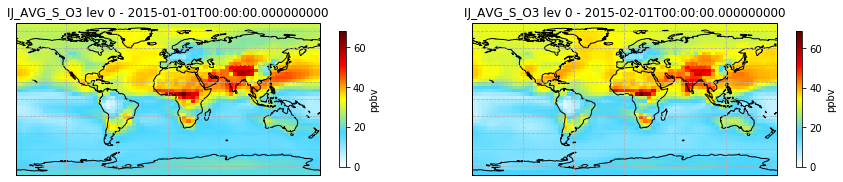

LEV 22


<Figure size 432x288 with 0 Axes>

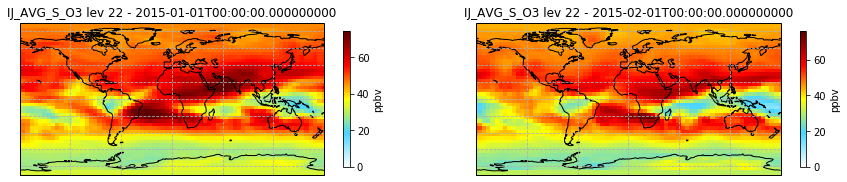

TRACER IJ_AVG_S_SO2
LEV 0


<Figure size 432x288 with 0 Axes>

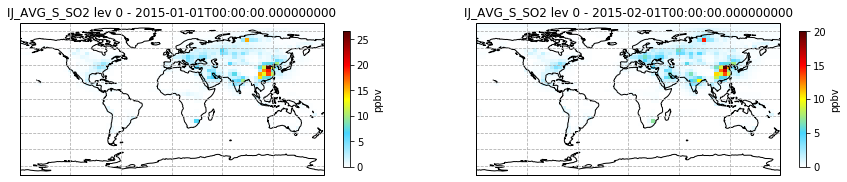

LEV 22


<Figure size 432x288 with 0 Axes>

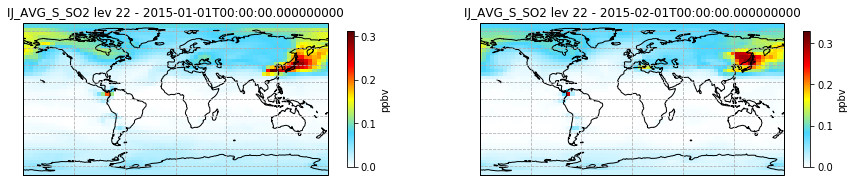

TRACER IJ_AVG_S_NH3
LEV 0


<Figure size 432x288 with 0 Axes>

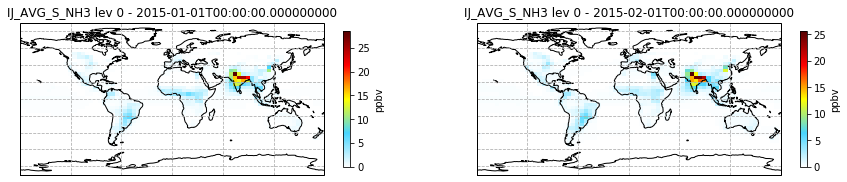

LEV 22


<Figure size 432x288 with 0 Axes>

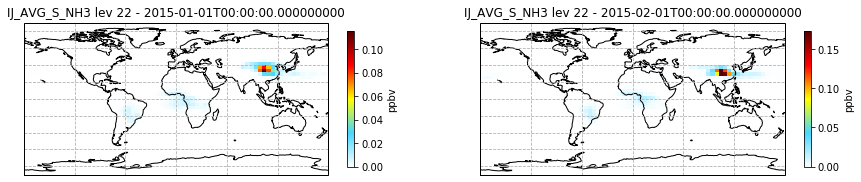

TRACER IJ_AVG_S_NO2
LEV 0


<Figure size 432x288 with 0 Axes>

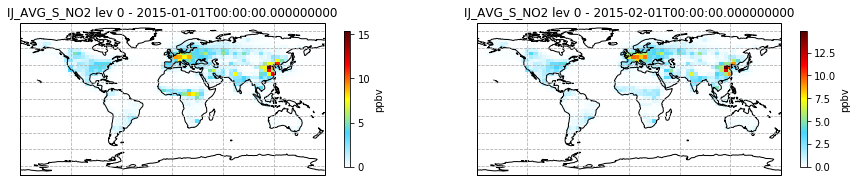

LEV 22


<Figure size 432x288 with 0 Axes>

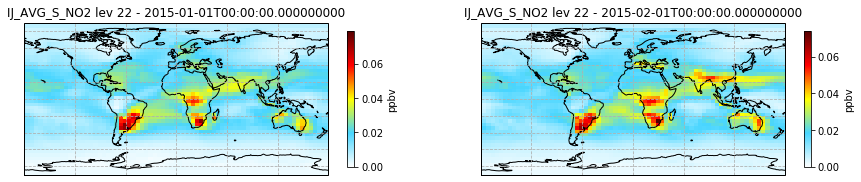

<Figure size 432x288 with 0 Axes>

In [27]:
plot_static(
    emiss=df_trac,
    tracers=['ACETSRCE_ACETbg', 'IJ_AVG_S_O3', 'IJ_AVG_S_SO2', 'IJ_AVG_S_NH3', 'IJ_AVG_S_NO2'],
    times=[0, 1],
    levs=[0, 22],
    save=True
)

#### Interactive

In [29]:
@interact(
    variable=Dropdown(options=variables, continuous_update=False), 
    lev=IntSlider(min=0, max=46, step=1, continuous_update=False),
)
def plot_dynamic(variable, lev):
    try:
        _ = plt.figure(figsize=[15, 7])
        ax = plt.axes(projection=ccrs.PlateCarree())
        ax.coastlines()
        ax.gridlines(linestyle="--")
        kwargs = {"time": 0}
        
        if "lev" in df_trac[variable].dims:
            kwargs["lev"] = lev
        else:
            lev = "there is no lev"
            
        df_trac[variable].isel(**kwargs).plot(ax=ax, cmap=WhGrYlRd)
        ax.set_title(variable + f"; lev={lev}")
    except Exception as e:
        print(f"{e}")

interactive(children=(Dropdown(description='variable', options=('ACETSRCE_ACETbg', 'ACETSRCE_ACETmb', 'ACETSRC…

Fonte: [GEOSChem-python-tutorial](https://github.com/geoschem/GEOSChem-python-tutorial)